In [1]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#parameters 
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [3]:
def train(train_loader, model, criterion, optimizer, device):
    
    model.train() #train mode modifying the weights
    running_loss = 0 #setting initial loss to zero
    
    for X, y_true in train_loader:
        
        optimizer.zero_grad() #setting starting gradient to zero
        
        X = X.to(device) #send data to device
        y_true = y_true.to(device)
        
        #Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true) #criterion = loss function
        running_loss += loss.item() *X.size(0) #update loss
        
        #Backward pass
        loss.backward() #back propagation
        optimizer.step() #optimizer updates
        
    epoch_loss = running_loss/len(train_loader.dataset) #average loss per epoch
    return model, optimizer, epoch_loss

In [4]:
def validate(valid_loader, model, criterion, device):
    
    model.eval()
    running_loss = 0
    
    for X,y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true) #criterion: metric for comparison
        running_loss += loss.item() *X.size(0)
        
    epoch_loss = running_loss/len(valid_loader.dataset)
    
    return model, epoch_loss

In [5]:
def training_loop(model, criterion, 
                  optimizer, train_loader, 
                  valid_loader, epochs, 
                  device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training 
        '''
        Send training data to the model defined above, 
        specify what model, criterion, optimizer and 
        device we are using in the parameter
        '''
        model, optimizer, train_loss = train(
            train_loader, 
            model, 
            criterion, 
            optimizer, 
            device)
        # append loss after each iteration
        train_losses.append(train_loss)

        # validation
        '''
        Turn off the gradient 
        then send testing data through data loader
        specify model, criterion and which device to send
        append loss among testing dataset
        '''
        with torch.no_grad():
            model, valid_loss = validate(
                valid_loader, 
                model, 
                criterion, 
                device)
            valid_losses.append(valid_loss)

        # Specify print every N loops
        if epoch % print_every == (print_every - 1):
            
            #print training and testing data accuracy
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    #plot training and testing loss
    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [7]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [8]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [9]:
class LeNet5(nn.Module):
    
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        # define the NN architecture
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        # like softmax, the last part of the network
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 120, out_features = 84),
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features = n_classes)
        )
        
    # Workflow of your network    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1) #because linear function doens't take 2d tensor
        logits = self.classifier(x) #vector of probabilities of each 10 number
        probs = F.softmax(logits, dim=1) #pick up the highest prob number
        return logits, probs

In [10]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

10:59:49 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
11:00:24 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
11:00:58 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
11:01:32 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
11:02:06 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.74
11:02:40 --- Epoch: 5	Train loss: 0.0300	Valid loss: 0.0436	Train accuracy: 99.37	Valid accuracy: 98.62
11:03:14 --- Epoch: 6	Train loss: 0.0247	Valid loss: 0.0428	Train accuracy: 99.48	Valid accuracy: 98.61
11:03:48 --- Epoch: 7	Train loss: 0.0223	Valid loss: 0.0432	Train accuracy: 99.49	Valid accuracy: 98.52
11:04:22 --- Epoch: 8	Train loss: 0.0184	Valid loss: 0.0432	Train accuracy: 99.58	Valid accuracy: 98.74
11:04:56 --- Epoch: 9	Train loss: 0.0170	Valid loss: 0.0478	Trai

/var/folders/vk/1_09993s7yqf2xwq6qz13xmw0000gn/T/ipykernel_65916/1591329956.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/vk/1_09993s7yqf2xwq6qz13xmw0000gn/T/ipykernel_65916/1591329956.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


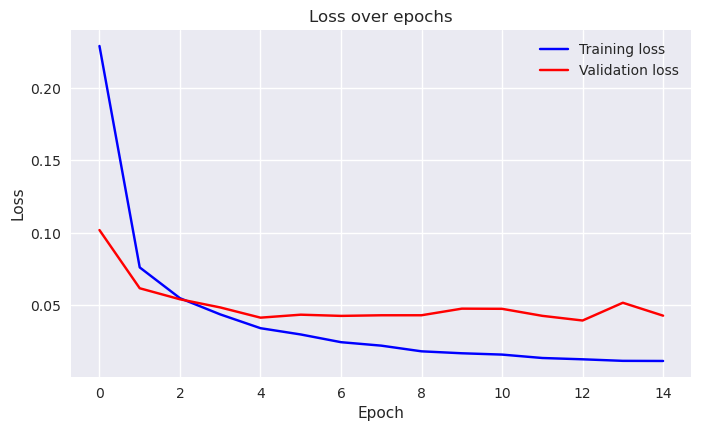

In [11]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)
